# Implementation

In [3]:
import numpy as np
import pandas as pd
import time

In [262]:
def simplex_method(A: np.array, c: np.array, b: np.array, x_0: np.array):
    # determine execution time of algorithm
    starting_time = time.time()
    
    m, n = A.shape
    
    if any(x_0 < 0): 
        x_0 = phase_1(A,b)
        print(f"New feasible point choosen: {x_0}")
    
    # calcualte calligraphic B and N (Basic- and NonBasic Index Sets)
    nonbasic_index_set = np.where(x_0==0)[0][:n-m] # Nonbasic index set (calligraphic N)
    basic_index_set = np.setdiff1d(np.arange(n), nonbasic_index_set) # Basis (calligraphic B)
    
    x = x_0
    
    df = pd.DataFrame(columns=['Iteration', 'Basic', 'Non-Basic', 'x_B','x_N', 'x_old', 'lambda', 's_N', 's_N>=0, Optimal sol.?', 'q', 'd', 'd<=0, Unbounded problem?', 'x_B_plus', 'x_N_plus', 'x_new'])
    df.loc[len(df)] = [0, basic_index_set, nonbasic_index_set, '---', '---', np.round(x_0, 3), '---', '---', False, '---', '---', False, '---', '---', '---']
    
    iterations=1
    break_out_condition = -1
    """
    do simplex method until either:
        - find optimal point (0)
        - detect unboundness (1)
        - Errors (2)
    """
    while True:
        # calcualte B, N

        B = A[:, basic_index_set]
        N = A[:, nonbasic_index_set]

        # calcualte x_B, x_N
        x_B = np.linalg.inv(B) @ b
        x_N = np.zeros(c.shape[0] - b.shape[0])

        # calcualte c_B and c_N
        c_B = c[basic_index_set]
        c_N = c[nonbasic_index_set]

        # get lambda
        lambda_ = np.linalg.solve(B.T, c_B)

        # calculate s_N
        s_N = np.subtract(c_N, (N.T @ lambda_))
        
        is_optimal_sol = False
        # 1st exit condition: Optimal point found
        if np.all(s_N >= 0): 
            break_out_condition = 0
            df.loc[len(df)] = [iterations, basic_index_set, nonbasic_index_set, np.round(x_B, 3), np.round(x_N, 3), np.round(x, 3), np.round(lambda_, 3), np.round(s_N, 3), True, 
                               '---', '---', False, '---', '---', '---']
            return df, x, f'Algorithm took {(time.time() - starting_time) * 1000} ms to run'

        # select q
        min_s_N = np.argmin(s_N) 
        q_min_idx = nonbasic_index_set[min_s_N] 
        

        # get d
        A_q = A[:, q_min_idx] 
        d = np.linalg.solve(B, A_q)

        # 2nd exit condition: problem is unbounded
        if np.all(d <= 0): 
            break_out_condition = 1
            df.loc[len(df)] = [iterations, basic_index_set, nonbasic_index_set, np.round(x_B, 3), np.round(x_N, 3), np.round(x, 3), np.round(lambda_, 3), np.round(s_N, 3), False, 
                               q_min_idx, d, False, np.round(x_B_plus, 3), np.round(x_N_plus, 3), np.round(x_new, 3)]
            return df, _, f'Algorithm took {(time.time() - starting_time) * 1000} ms to run'

        # calcualte x_q^+ and p
        x_q_plus_all = []
        for i, d_i in enumerate(d):
            if d_i > 0:
                x_q_plus_all += [x_B[i]/d_i]
                
        if len(x_q_plus_all) == 0: raise ValueError('Could not find any appropriate q')
        
        
        
        p_min_idx = np.argmin(x_q_plus_all)
        
        x_q_plus = np.min(x_q_plus_all)

        # positive d elements
        d_index = np.where(d > 0)[0] 
        ratios = x_B[d_index] / d[d_index]
        # get min of ratios
        x_q_plus = np.min(ratios) 
        p_min_idx = d_index[np.argmin(ratios)] 

        # update x_B^+
        x_B_plus = np.subtract(x_B, (d * x_q_plus))

        # update x_N_^+
        x_N_plus = x_N
        entering_var = -1 # needed for updating N and x_N_plus

        entering_var = np.where(nonbasic_index_set == q_min_idx)[0]
        # check for validity of varaible that changes N and x_N_plus
        if entering_var == -1: raise ValueError('Entering variable for N is undefined')
        x_N_plus[entering_var] = x_q_plus
        
        # update x according to indices
        x_new = x.copy()
        x_new[basic_index_set] = x_B_plus
        x_new[nonbasic_index_set] = x_N_plus

        # update basic- and nonbasic index set
        basic_index_set_copy = basic_index_set.copy()
        basic_index_set[p_min_idx] = q_min_idx
        nonbasic_index_set[entering_var] = basic_index_set_copy[p_min_idx]       
        
        df.loc[len(df)] = [iterations, basic_index_set, nonbasic_index_set, np.round(x_B, 3), np.round(x_N, 3), np.round(x, 3), np.round(lambda_, 3), np.round(s_N, 3), False, 
                            q_min_idx, d, False, np.round(x_B_plus, 3), np.round(x_N_plus, 3), np.round(x_new, 3)]
        x = x_new
        iterations += 1

In [133]:
def phase_1(A,b):  
    # initialize the "subject"
    e = np.concatenate((np.zeros(A.shape[1]), np.ones(A.shape[0])))

    # initialize E matrix
    E = np.diag(-1 + 2 * (b >= 0))
    A_new = np.hstack((A, E))
    #get initial point
    x_triv = np.concatenate((np.zeros(A.shape[1]), np.abs(b))) 
    # solve new problem
    df, optimal_point, execution_time = simplex_method(A_new,e, b, x_triv)
    
    x0 = optimal_point[:A.shape[1]]
    return x0

# 2D Problems

## Problem 1 (13.1 from Book)

min:$$ -4x_1-2x_2$$
subject to:
$$x_1+x_2 <= 5$$
$$2x_1+\frac{1}{2}x_2<=8$$
it can be graphically seen, that the solution needs to be the intersection of the two constraints, which gives the point $x^*=(\frac{4}{3}, \frac{11}{3})$ as the solution

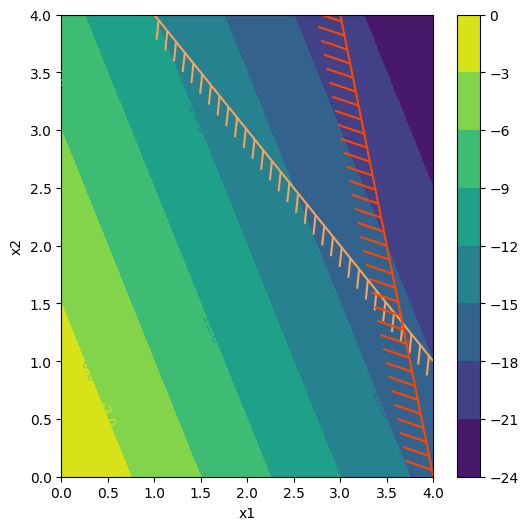

In [212]:
import matplotlib.pyplot as plt
from matplotlib import patheffects

fig, ax = plt.subplots(figsize=(6, 6))

nx = 101
ny = 105

xvec = np.linspace(0.001, 4.0, nx)
yvec = np.linspace(0.001, 4.0, ny)

x1, x2 = np.meshgrid(xvec, yvec)

obj = -4*x1-2* x2
g1 = -(x1 + x2 - 5)
g2 = -(2*x1 + 1/2*x2 - 8)

cp = ax.contourf(x1, x2, obj)
fig.colorbar(cp)
ax.clabel(cp, fmt="%2.1f", use_clabeltext=True)

cg1 = ax.contour(x1, x2, g1, [0], colors='sandybrown')
plt.setp(cg1.collections,
         path_effects=[patheffects.withTickedStroke(angle=135)])

cg2 = ax.contour(x1, x2, g2, [0], colors='orangered')
plt.setp(cg2.collections,
         path_effects=[patheffects.withTickedStroke(angle=60, length=2)])
plt.xlabel("x1")
plt.ylabel("x2")


ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

plt.show()

### Starting point (0,0) feasible

In [160]:
A_con = np.array([[1,1],
              [2,1/2]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([5, 8], dtype=np.float64)
c = np.array([-4, -2], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([0, 0], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[1, 0]","[3, 2]",---,---,"[0.0, 0.0, 5.0, 8.0]",---,---,False,---,---,False,---,---,---
1,1,"[1, 0]","[3, 2]","[5.0, 8.0]","[4.0, 0.0]","[0.0, 0.0, 5.0, 8.0]","[0.0, 0.0]","[-4.0, -2.0]",False,0,"[1.0, 2.0]",False,"[1.0, 0.0]","[4.0, 0.0]","[4.0, 0.0, 1.0, 0.0]"
2,2,"[1, 0]","[3, 2]","[1.0, 4.0]","[0.0, 1.333]","[4.0, 0.0, 1.0, 0.0]","[0.0, -2.0]","[2.0, -1.0]",False,1,"[0.75, 0.25]",False,"[0.0, 3.667]","[0.0, 1.333]","[3.667, 1.333, 0.0, 0.0]"
3,3,"[1, 0]","[3, 2]","[1.333, 3.667]","[0.0, 0.0]","[3.667, 1.333, 0.0, 0.0]","[-1.333, -1.333]","[1.333, 1.333]",True,---,---,False,---,---,---


In [115]:
optimal_point

array([3.66666667, 1.33333333, 0.        , 0.        ])

In [116]:
execution_time

'Algorithm took 13.005495071411133 ms to run'

### Starting point (4,3) infeasible

In [154]:
# Example 13.1 from book:
A_con = np.array([[1,1],
              [2,1/2]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([5, 8], dtype=np.float64)
c = np.array([-4, -2], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([4, 3], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [4. 0. 1. 0.]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 1]","[2, 3]",---,---,"[4.0, 0.0, 1.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 1]","[2, 3]","[4.0, 1.0]","[1.333, 0.0]","[4.0, 0.0, 1.0, 0.0]","[0.0, -2.0]","[-1.0, 2.0]",False,1,"[0.25, 0.75]",False,"[3.667, 0.0]","[1.333, 0.0]","[3.667, 1.333, 0.0, 0.0]"
2,2,"[0, 1]","[2, 3]","[3.667, 1.333]","[0.0, 0.0]","[3.667, 1.333, 0.0, 0.0]","[-1.333, -1.333]","[1.333, 1.333]",True,---,---,False,---,---,---


In [135]:
optimal_point

array([3.66666667, 1.33333333, 0.        , 0.        ])

In [136]:
execution_time

'Algorithm took 27.004241943359375 ms to run'

## Problem 2 (13.9 from the book)

min:$$ -5x_1-x_2$$
subject to:
$$x_1+x_2 <= 5$$
$$2x_1+\frac{1}{2}x_2<=8$$
it can be graphically seen, that the solution needs to be the intersection of the two "red"-constraint with the x1-axes, which gives the point $x^*=(4, 0)$ as the solution

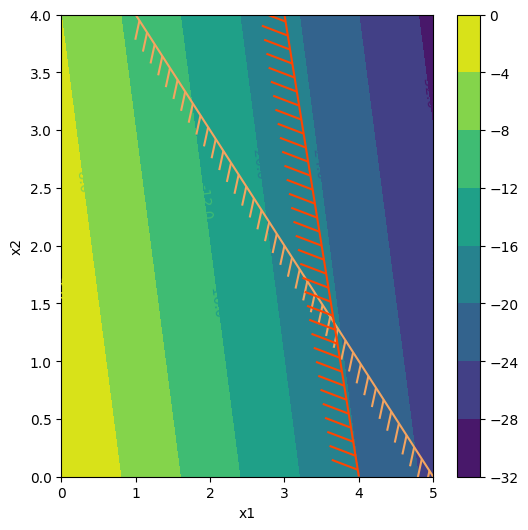

In [180]:
fig, ax = plt.subplots(figsize=(6, 6))

nx = 101
ny = 105

xvec = np.linspace(0.001, 5.0, nx)
yvec = np.linspace(0.001, 4.0, ny)

x1, x2 = np.meshgrid(xvec, yvec)

obj = -5*x1-1* x2
g1 = -(x1 + x2 - 5)
g2 = -(2*x1 + 1/2*x2 - 8)

cp = ax.contourf(x1, x2, obj)
fig.colorbar(cp)
ax.clabel(cp, fmt="%2.1f", use_clabeltext=True)

cg1 = ax.contour(x1, x2, g1, [0], colors='sandybrown')
plt.setp(cg1.collections,
         path_effects=[patheffects.withTickedStroke(angle=135)])

cg2 = ax.contour(x1, x2, g2, [0], colors='orangered')
plt.setp(cg2.collections,
         path_effects=[patheffects.withTickedStroke(angle=60, length=2)])
plt.xlabel("x1")
plt.ylabel("x2")



ax.set_xlim(0, 5)
ax.set_ylim(0, 4)

plt.show()

### Starting point (0,0) feasible

In [197]:
A_con = np.array([[1,1],
              [2,1/2]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([5, 8], dtype=np.float64)
c = np.array([-5, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([0, 0], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[2, 0]","[3, 1]",---,---,"[0.0, 0.0, 5.0, 8.0]",---,---,False,---,---,False,---,---,---
1,1,"[2, 0]","[3, 1]","[5.0, 8.0]","[4.0, 0.0]","[0.0, 0.0, 5.0, 8.0]","[0.0, 0.0]","[-5.0, -1.0]",False,0,"[1.0, 2.0]",False,"[1.0, 0.0]","[4.0, 0.0]","[4.0, 0.0, 1.0, 0.0]"
2,2,"[2, 0]","[3, 1]","[1.0, 4.0]","[0.0, 0.0]","[4.0, 0.0, 1.0, 0.0]","[0.0, -2.5]","[2.5, 0.25]",True,---,---,False,---,---,---


In [162]:
optimal_point

array([4., 0., 1., 0.])

In [163]:
execution_time

'Algorithm took 10.054349899291992 ms to run'

### Starting point (5,5) infeasible

In [169]:
A_con = np.array([[1,1],
              [2,1/2]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([5, 8], dtype=np.float64)
c = np.array([-5, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([5, 5], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [4. 0. 1. 0.]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 2]","[1, 3]",---,---,"[4.0, 0.0, 1.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 2]","[1, 3]","[4.0, 1.0]","[0.0, 0.0]","[4.0, 0.0, 1.0, 0.0]","[0.0, -2.5]","[0.25, 2.5]",True,---,---,False,---,---,---


In [170]:
optimal_point

array([4., 0., 1., 0.])

In [171]:
execution_time

'Algorithm took 21.945714950561523 ms to run'

## Problem 3

min:$$ -5x_1-x_2$$
subject to:
$$5x_1-x_2 <= 3$$
$$2x_1+1x_2<=4$$
it can be graphically seen, that the solution needs to be the intersection of the two constraints, which gives the point $x^*=(1,2)$ as the solution

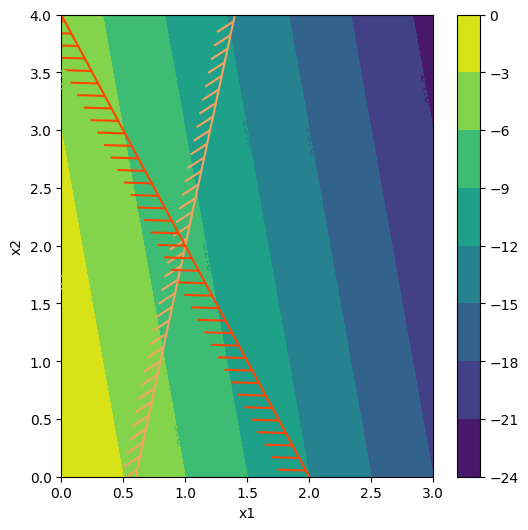

In [185]:
fig, ax = plt.subplots(figsize=(6, 6))

nx = 101
ny = 105

xvec = np.linspace(0.001, 3.0, nx)
yvec = np.linspace(0.001, 4.0, ny)

x1, x2 = np.meshgrid(xvec, yvec)

obj = -6*x1-1* x2
g1 = -(5*x1 - x2 - 3)
g2 = -(2*x1 + x2 - 4)

cp = ax.contourf(x1, x2, obj)
fig.colorbar(cp)
ax.clabel(cp, fmt="%2.1f", use_clabeltext=True)

cg1 = ax.contour(x1, x2, g1, [0], colors='sandybrown')
plt.setp(cg1.collections,
         path_effects=[patheffects.withTickedStroke(angle=135)])

cg2 = ax.contour(x1, x2, g2, [0], colors='orangered')
plt.setp(cg2.collections,
         path_effects=[patheffects.withTickedStroke(angle=60, length=2)])
plt.xlabel("x1")
plt.ylabel("x2")



ax.set_xlim(0, 3)
ax.set_ylim(0, 4)

plt.show()

### Starting point (0,0) feasible

In [193]:
A_con = np.array([[5,-1],
              [2,1]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([3, 4], dtype=np.float64)
c = np.array([-6, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([0, 0], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 1]","[2, 3]",---,---,"[0.0, 0.0, 3.0, 4.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 1]","[2, 3]","[3.0, 4.0]","[0.6, 0.0]","[0.0, 0.0, 3.0, 4.0]","[0.0, 0.0]","[-6.0, -1.0]",False,0,"[5.0, 2.0]",False,"[0.0, 2.8]","[0.6, 0.0]","[0.6, 0.0, 0.0, 2.8]"
2,2,"[0, 1]","[2, 3]","[0.6, 2.8]","[0.0, 2.0]","[0.6, 0.0, 0.0, 2.8]","[-1.2, 0.0]","[1.2, -2.2]",False,1,"[-0.2, 1.4]",False,"[1.0, 0.0]","[0.0, 2.0]","[1.0, 2.0, 0.0, 0.0]"
3,3,"[0, 1]","[2, 3]","[1.0, 2.0]","[0.0, 0.0]","[1.0, 2.0, 0.0, 0.0]","[-0.571, -1.571]","[0.571, 1.571]",True,---,---,False,---,---,---


In [187]:
optimal_point

array([1., 2., 0., 0.])

In [188]:
execution_time

'Algorithm took 13.047218322753906 ms to run'

### Starting point (1,1) infeasible

In [189]:
A_con = np.array([[5,-1],
              [2,1]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([3, 4], dtype=np.float64)
c = np.array([-6, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([1, 1], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [1. 2. 0. 0.]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 1]","[2, 3]",---,---,"[1.0, 2.0, 0.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 1]","[2, 3]","[1.0, 2.0]","[0.0, 0.0]","[1.0, 2.0, 0.0, 0.0]","[-0.571, -1.571]","[0.571, 1.571]",True,---,---,False,---,---,---


In [190]:
optimal_point

array([1., 2., 0., 0.])

In [191]:
execution_time

'Algorithm took 22.00031280517578 ms to run'

## Problem 4

min:$$ -x_1-8x_2$$
subject to:
$$-2x_1+8x_2 <= 4$$
$$x_1-2x_2<=4$$
$$2x_1-x_2<=10$$
it can be graphically seen, that the solution needs to be the intersection of the "red"- and "yellow"-constraint, which gives the point $x^*=(6,2)$ as the solution

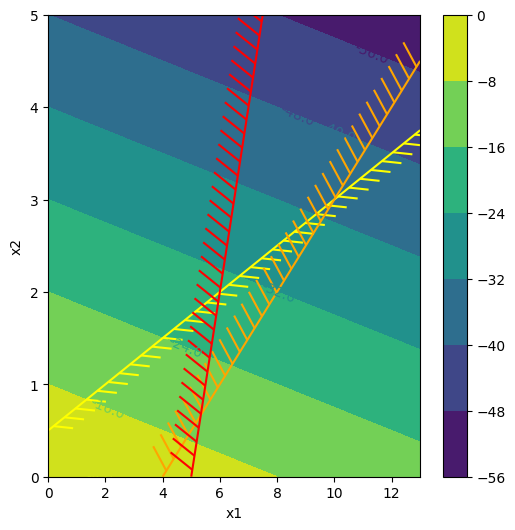

In [292]:
fig, ax = plt.subplots(figsize=(6, 6))

nx = 101
ny = 105

xvec = np.linspace(0.001, 13.0, nx)
yvec = np.linspace(0.001, 5.0, ny)

x1, x2 = np.meshgrid(xvec, yvec)

obj = -1*x1-8* x2
g1 = -(-2*x1 +8* x2 - 4)
g2 = -(1*x1 - 2*x2 - 4)
g3 = -(2*x1 - 1*x2 - 10)

cp = ax.contourf(x1, x2, obj)
fig.colorbar(cp)
ax.clabel(cp, fmt="%2.1f", use_clabeltext=True)

cg1 = ax.contour(x1, x2, g1, [0], colors='yellow')
plt.setp(cg1.collections,
         path_effects=[patheffects.withTickedStroke(angle=135)])

cg2 = ax.contour(x1, x2, g2, [0], colors='orange')
plt.setp(cg2.collections,
         path_effects=[patheffects.withTickedStroke(angle=60, length=2)])

cg3 = ax.contour(x1, x2, g3, [0], colors='red')
plt.setp(cg3.collections,
         path_effects=[patheffects.withTickedStroke(angle=60, length=2)])

plt.xlabel("x1")
plt.ylabel("x2")



ax.set_xlim(0, 13)
ax.set_ylim(0, 5)

plt.show()

### Starting point (0,0) feasible

In [233]:
A_con = np.array([[-2,8],
                  [1,-2],
                  [2,-1]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([4, 4,10], dtype=np.float64)
c = np.array([-1, -8], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([0, 0], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[1, 3, 0]","[4, 2]",---,---,"[0.0, 0.0, 4.0, 4.0, 10.0]",---,---,False,---,---,False,---,---,---
1,1,"[1, 3, 0]","[4, 2]","[4.0, 4.0, 10.0]","[0.0, 0.5]","[0.0, 0.0, 4.0, 4.0, 10.0]","[0.0, 0.0, 0.0]","[-1.0, -8.0]",False,1,"[8.0, -2.0, -1.0]",False,"[0.0, 5.0, 10.5]","[0.0, 0.5]","[0.0, 0.5, 0.0, 5.0, 10.5]"
2,2,"[1, 3, 0]","[4, 2]","[0.5, 5.0, 10.5]","[6.0, 0.0]","[0.0, 0.5, 0.0, 5.0, 10.5]","[-1.0, 0.0, 0.0]","[-3.0, 1.0]",False,0,"[-0.25, 0.5, 1.75]",False,"[2.0, 2.0, 0.0]","[6.0, 0.0]","[6.0, 2.0, 0.0, 2.0, 0.0]"
3,3,"[1, 3, 0]","[4, 2]","[2.0, 2.0, 6.0]","[0.0, 0.0]","[6.0, 2.0, 0.0, 2.0, 0.0]","[-1.214, 0.0, -1.714]","[1.714, 1.214]",True,---,---,False,---,---,---


In [234]:
optimal_point

array([6., 2., 0., 2., 0.])

In [235]:
execution_time

'Algorithm took 18.004179000854492 ms to run'

### Starting point (1,1) infeasible

In [236]:
A_con = np.array([[-2,8],
                  [1,-2],
                  [2,-1]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([4, 4,10], dtype=np.float64)
c = np.array([-1, -8], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([1, 1], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [6. 2. 0. 2. 0.]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 1, 3]","[2, 4]",---,---,"[6.0, 2.0, 0.0, 2.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 1, 3]","[2, 4]","[6.0, 2.0, 2.0]","[0.0, 0.0]","[6.0, 2.0, 0.0, 2.0, 0.0]","[-1.214, 0.0, -1.714]","[1.214, 1.714]",True,---,---,False,---,---,---


In [237]:
optimal_point

array([6., 2., 0., 2., 0.])

In [238]:
execution_time

'Algorithm took 22.000789642333984 ms to run'

## Problem 5

min:$$ x_1+6x_2$$
subject to:
$$-x_1-x_2 <= -5$$
$$-x_1+2x_2<=8$$
$$x_2<=8$$
$$x_1-x_2<=3$$
it can be graphically seen, that the solution needs to be the intersection of the "purple"- and "yellow"-constraint, which gives the point $x^*=(4,1)$ as the solution

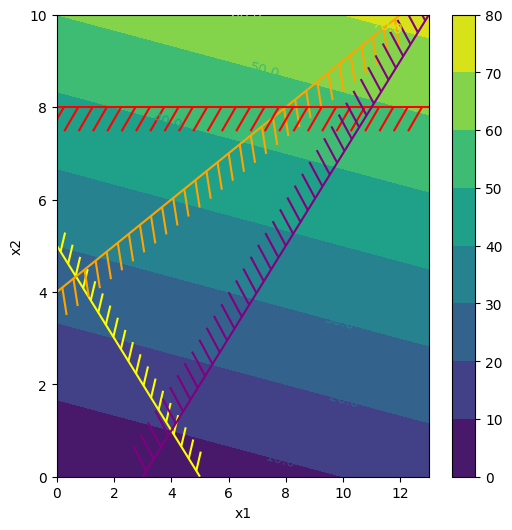

In [219]:
fig, ax = plt.subplots(figsize=(6, 6))

nx = 101
ny = 105

xvec = np.linspace(0.001, 13.0, nx)
yvec = np.linspace(0.001, 10.0, ny)

x1, x2 = np.meshgrid(xvec, yvec)

obj = 1*x1+6* x2
g1 = -(-1*x1 -1* x2 + 5)
g2 = -(-1*x1 + 2*x2 - 8)
g3 = -(0*x1 + 1*x2 - 8)
g4 = -(1*x1 - 1*x2 - 3)

cp = ax.contourf(x1, x2, obj)
fig.colorbar(cp)
ax.clabel(cp, fmt="%2.1f", use_clabeltext=True)

cg1 = ax.contour(x1, x2, g1, [0], colors='yellow')
plt.setp(cg1.collections,
         path_effects=[patheffects.withTickedStroke(angle=135)])

cg2 = ax.contour(x1, x2, g2, [0], colors='orange')
plt.setp(cg2.collections,
         path_effects=[patheffects.withTickedStroke(angle=60, length=2)])

cg3 = ax.contour(x1, x2, g3, [0], colors='red')
plt.setp(cg3.collections,
         path_effects=[patheffects.withTickedStroke(angle=60, length=2)])

cg4 = ax.contour(x1, x2, g4, [0], colors='purple')
plt.setp(cg4.collections,
         path_effects=[patheffects.withTickedStroke(angle=60, length=2)])

plt.xlabel("x1")
plt.ylabel("x2")



ax.set_xlim(0, 13)
ax.set_ylim(0, 10)

plt.show()

### Starting point (11,8) feasible

In [222]:
A_con = np.array([[-1,-1],
                  [-1,2],
                  [0,1],
                  [1,-1]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([-5, 8,8,3], dtype=np.float64)
c = np.array([1, 6], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([11, 8], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 1, 4, 3]","[2, 5]",---,---,"[11.0, 8.0, 14.0, 3.0, 0.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 1, 4, 3]","[2, 5]","[11.0, 8.0, 14.0, 3.0]","[7.0, 0.0]","[11.0, 8.0, 14.0, 3.0, 0.0, 0.0]","[-0.0, 0.0, 7.0, 1.0]","[-7.0, -1.0]",False,4,"[1.0, 1.0, 2.0, -1.0000000000000002]",False,"[4.0, 1.0, 0.0, 10.0]","[7.0, 0.0]","[4.0, 1.0, 0.0, 10.0, 7.0, 0.0]"
2,2,"[0, 1, 4, 3]","[2, 5]","[4.0, 1.0, 7.0, 10.0]","[0.0, 0.0]","[4.0, 1.0, 0.0, 10.0, 7.0, 0.0]","[-3.5, 0.0, 0.0, -2.5]","[3.5, 2.5]",True,---,---,False,---,---,---


In [221]:
optimal_point

array([ 4.,  1.,  0., 10.,  7.,  0.])

In [223]:
execution_time

'Algorithm took 10.051488876342773 ms to run'

### Starting point (6,12) infeasible

In [229]:
A_con = np.array([[-1,-1],
                  [-1,2],
                  [0,1],
                  [1,-1]])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([-5, 8,8,3], dtype=np.float64)
c = np.array([1, 6], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([6, 12], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [0.66666667 4.33333333 0.         0.         3.66666667 6.66666667]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 1, 4, 3]","[2, 5]",---,---,"[0.667, 4.333, 0.0, 0.0, 3.667, 6.667]",---,---,False,---,---,False,---,---,---
1,1,"[0, 1, 4, 3]","[2, 5]","[0.667, 4.333, 3.667, 6.667]","[0.0, 10.0]","[0.667, 4.333, 0.0, 0.0, 3.667, 6.667]","[-2.667, 1.667, 0.0, 0.0]","[2.667, -1.667]",False,3,"[-0.3333333333333333, 0.3333333333333333, -0.3...",False,"[4.0, 1.0, 7.0, 0.0]","[0.0, 10.0]","[4.0, 1.0, 0.0, 10.0, 7.0, 0.0]"
2,2,"[0, 1, 4, 3]","[2, 5]","[4.0, 1.0, 7.0, 10.0]","[0.0, 0.0]","[4.0, 1.0, 0.0, 10.0, 7.0, 0.0]","[-3.5, 0.0, 0.0, -2.5]","[3.5, 2.5]",True,---,---,False,---,---,---


In [230]:
optimal_point

array([ 4.,  1.,  0., 10.,  7.,  0.])

In [231]:
execution_time

'Algorithm took 30.081748962402344 ms to run'

# 10d Problems

## Problem 1

min:$$ -x_1-x_2-x_3-x_4-x_5-x_6-x_7-x_8-x_9-x_{10}$$
subject to:
$$2x_1 <= 1$$
$$x_2 <= 1$$
$$x_3 <= 1$$
$$x_4 <= 1$$
$$x_5 <= 1$$
$$x_6 <= 1$$
$$x_7 <= 1$$
$$x_8 <= 1$$
$$x_9 <= 1$$
$$x_{10}<= 1$$

### Starting point (0,0,0,0,0,0,0,0,0,0) feasible

In [260]:
A_con = np.array([[2,0,0,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([1, 1,1,1,1,1,1,1,1,1], dtype=np.float64)
c = np.array([-1, -1,-1, -1,-1, -1,-1, -1,-1, -1,], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([0, 0,0,0,0,0,0,0,0,0], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

[10 11 12 13 14 15 16 17 18 19]
[ 0 11 12 13 14 15 16 17 18 19]
[ 0  1 12 13 14 15 16 17 18 19]
[ 0  1  2 13 14 15 16 17 18 19]
[ 0  1  2  3 14 15 16 17 18 19]
[ 0  1  2  3  4 15 16 17 18 19]
[ 0  1  2  3  4  5 16 17 18 19]
[ 0  1  2  3  4  5  6 17 18 19]
[ 0  1  2  3  4  5  6  7 18 19]
[ 0  1  2  3  4  5  6  7  8 19]
[0 1 2 3 4 5 6 7 8 9]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]",---,---,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,0,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-0.5, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-0.5, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
5,5,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-0.5, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
6,6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 

In [243]:
optimal_point

array([0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [245]:
execution_time

'Algorithm took 52.99830436706543 ms to run'

### Starting point (1,1,1,1,1,1,1,1,1,1) infeasible

In [255]:
A_con = np.array([[2,0,0,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([1, 1,1,1,1,1,1,1,1,1], dtype=np.float64)
c = np.array([-1, -1,-1, -1,-1, -1,-1, -1,-1, -1,], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([1, 1,1,1,1,1,1,1,1,1], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0. ]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]",---,---,"[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.5, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",True,---,---,False,---,---,---


In [256]:
optimal_point

array([0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [258]:
execution_time

'Algorithm took 57.07597732543945 ms to run'

## Problem 2

min:$$ -x_1-x_2-x_3-x_4-x_5-x_6-x_7-x_8-x_9-x_{10}$$
subject to:
$$x_1+4x_2 <= 3$$
$$x_2 <= 1$$
$$x_3 <= 1$$
$$x_4 <= 1$$
$$x_5 <= 1$$
$$x_6 <= 1$$
$$x_7 <= 1$$
$$x_8 <= 1$$
$$x_9 <= 1$$
$$x_{10}<= 1$$

### Starting point (0,0,0,0,0,0,0,0,0,0) feasible

In [268]:
A_con = np.array([[1,4,0,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([3, 1,1,1,1,1,1,1,1,1], dtype=np.float64)
c = np.array([-1, -1,-1, -1,-1, -1,-1, -1,-1, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([0, 0,0,0,0,0,0,0,0,0], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 11, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 1, 12, 13, 14, 15, 16, 17, 18, 19]",---,---,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 11, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 1, 12, 13, 14, 15, 16, 17, 18, 19]","[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2,2,"[0, 11, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 1, 12, 13, 14, 15, 16, 17, 18, 19]","[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 3.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[3.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,3,"[0, 11, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 1, 12, 13, 14, 15, 16, 17, 18, 19]","[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 3.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[3.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
4,4,"[0, 11, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 1, 12, 13, 14, 15, 16, 17, 18, 19]","[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 3.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[3.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
5,5,"[0, 11, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 1, 12, 13, 14, 15, 16, 17, 18, 19]","[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-1.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 3.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",False,"[3.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]"
6,6,"[0, 11, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 1, 12, 13, 14, 15, 16, 17, 18, 19]","[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,

In [272]:
optimal_point[:10]

array([3., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [265]:
execution_time

'Algorithm took 44.332265853881836 ms to run'

### Starting point (1,1,1,1,1,1,1,1,1,1) infeasible

In [274]:
A_con = np.array([[1,4,0,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([3, 1,1,1,1,1,1,1,1,1], dtype=np.float64)
c = np.array([-1, -1,-1, -1,-1, -1,-1, -1,-1, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([1, 1,1,1,1,1,1,1,1,1], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [0.   0.75 1.   1.   1.   1.   1.   1.   1.   1.   0.   0.25 0.   0.
 0.   0.   0.   0.   0.   0.  ]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 11]","[1, 10, 12, 13, 14, 15, 16, 17, 18, 19]",---,---,"[0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 11]","[1, 10, 12, 13, 14, 15, 16, 17, 18, 19]","[0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25]","[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.25, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[-0.75, 0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",False,0,"[0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.25]",False,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,2,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 11]","[1, 10, 12, 13, 14, 15, 16, 17, 18, 19]","[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",True,---,---,False,---,---,---


In [275]:
optimal_point[:10]

array([3., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [276]:
execution_time

'Algorithm took 61.1875057220459 ms to run'

## Problem 3

min:$$ -x_1-20x_2-x_3-x_4-x_5-x_6-x_7-x_8-x_9-x_{10}$$
subject to:
$$x_1+4x_2 <= 3$$
$$x_2 <= 1$$
$$x_3 <= 1$$
$$x_4 <= 4$$
$$x_5 <= 1$$
$$x_6 <= 1$$
$$x_7 <= 1$$
$$x_8+x_{10} <= 1$$
$$x_9 <= 1$$
$$x_{10}<= 1$$

### Starting point (0,0,0,0,0,0,0,0,0,0) feasible

In [293]:
A_con = np.array([[1,4,0,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,1],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([3, 1,1,4,1,1,1,1,1,1], dtype=np.float64)
c = np.array([-1, -20,-1, -1,-1, -1,-1, -1,-1, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([0, 0,0,0,0,0,0,0,0,0], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[1, 11, 2, 3, 4, 5, 6, 7, 8, 19]","[0, 10, 12, 13, 14, 15, 16, 17, 18, 9]",---,---,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",---,---,False,---,---,False,---,---,---
1,1,"[1, 11, 2, 3, 4, 5, 6, 7, 8, 19]","[0, 10, 12, 13, 14, 15, 16, 17, 18, 9]","[3.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-1.0, -20.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,1,"[4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.0, 0.25, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2,2,"[1, 11, 2, 3, 4, 5, 6, 7, 8, 19]","[0, 10, 12, 13, 14, 15, 16, 17, 18, 9]","[0.75, 0.25, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[4.0, 5.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.75, 0.25, 0.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
3,3,"[1, 11, 2, 3, 4, 5, 6, 7, 8, 19]","[0, 10, 12, 13, 14, 15, 16, 17, 18, 9]","[0.75, 0.25, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-5.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[4.0, 5.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.75, 0.25, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
4,4,"[1, 11, 2, 3, 4, 5, 6, 7, 8, 19]","[0, 10, 12, 13, 14, 15, 16, 17, 18, 9]","[0.75, 0.25, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-5.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[4.0, 5.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.75, 0.25, 1.0, 4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
5,5,"[1, 11, 2, 3, 4, 5, 6, 7, 8, 19]","[0, 10, 12, 13, 14, 15, 16, 17, 18, 9]","[0.75, 0.25, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[-5.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[4.0, 5.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.75, 0.25, 1.0, 4.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 1.0, 4.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]"
6,6,"[1, 11, 2, 3, 4, 5, 6, 7, 8, 19]","[0, 10, 12, 13, 14, 15, 16, 17, 18, 9]","[0.75, 0.25, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.75

In [294]:
optimal_point[:10]

array([0.  , 0.75, 1.  , 4.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  ])

In [295]:
execution_time

'Algorithm took 45.068979263305664 ms to run'

### Starting point (1,1,1,1,1,1,1,1,1,1) infeasible

In [296]:
A_con = np.array([[1,4,0,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,1],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([3, 1,1,4,1,1,1,1,1,1], dtype=np.float64)
c = np.array([-1, -20,-1, -1,-1, -1,-1, -1,-1, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([1, 1,1,1,1,1,1,1,1,1], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [0.   0.75 1.   4.   1.   1.   1.   0.   1.   1.   0.   0.25 0.   0.
 0.   0.   0.   0.   0.   0.  ]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[1, 2, 3, 4, 5, 6, 8, 9, 11, 19]","[0, 7, 10, 12, 13, 14, 15, 16, 17, 18]",---,---,"[0.0, 0.75, 1.0, 4.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[1, 2, 3, 4, 5, 6, 8, 9, 11, 19]","[0, 7, 10, 12, 13, 14, 15, 16, 17, 18]","[0.75, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.75, 1.0, 4.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-5.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0]","[4.0, 0.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",True,---,---,False,---,---,---


In [297]:
optimal_point[:10]

array([0.  , 0.75, 1.  , 4.  , 1.  , 1.  , 1.  , 0.  , 1.  , 1.  ])

In [298]:
execution_time

'Algorithm took 56.984901428222656 ms to run'

## Problem 4

min:$$ -x_1-x_2-x_3-x_4-x_5-x_6-x_7-x_8-x_9-x_{10}$$
subject to:
$$x_1+5x_2+12x_3+2x_4 <= 15$$
$$x_2+x_3 <= 3$$
$$x_3 <= 3$$
$$x_4 <= 3$$
$$x_5 <= 15$$
$$x_6 <= 3$$
$$x_7 <= 3$$
$$x_8 <= 3$$
$$x_9 <= 3$$
$$x_{10}<= 15$$

### Starting point (0,0,0,0,0,0,0,0,0,0) feasible

In [282]:
A_con = np.array([[1,5,12,2,0,0,0,0,0,0],
                  [0,1,1,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([15, 3,3,3,15,3,3,3,3,15], dtype=np.float64)
c = np.array([-1, -1,-1, -1,-1, -1,-1, -1,-1, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([0, 0,0,0,0,0,0,0,0,0], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 11, 12, 13, 4, 5, 6, 7, 8, 9]","[10, 1, 2, 3, 14, 15, 16, 17, 18, 19]",---,---,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 11, 12, 13, 4, 5, 6, 7, 8, 9]","[10, 1, 2, 3, 14, 15, 16, 17, 18, 19]","[15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]"
2,2,"[0, 11, 12, 13, 4, 5, 6, 7, 8, 9]","[10, 1, 2, 3, 14, 15, 16, 17, 18, 19]","[15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 4.0, 11.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[15.0, 3.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 15.0]"
3,3,"[0, 11, 12, 13, 4, 5, 6, 7, 8, 9]","[10, 1, 2, 3, 14, 15, 16, 17, 18, 19]","[15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 4.0, 11.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0]",False,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",False,"[15.0, 3.0, 3.0, 3.0, 15.0, 0.0, 3.0, 3.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 15.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 0.0, 3.0, 3.0, 3.0, 15.0]"
4,4,"[0, 11, 12, 13, 4, 5, 6, 7, 8, 9]","[10, 1, 2, 3, 14, 15, 16, 17, 18, 19]","[15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 15.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 0.0, 3.0, 3.0, 3.0, 15.0]","[-1.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 4.0, 11.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0]",False,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",False,"[15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 0.0, 3.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 15.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 3.0, 3.0, 15.0]"
5,5,"[0, 11, 12, 13, 4, 5, 6, 7, 8, 9]","[10, 1, 2, 3, 14, 15, 16, 17, 18, 19]","[15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 15.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 3.0, 3.0, 15.0]","[-1.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0]","[1.0, 4.0, 11.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0]",False,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",False,"[15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 0.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 15.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 3.0, 15.0]"
6,6,"[0, 11, 12, 13, 4, 5, 6, 7, 8, 9]","[10, 1, 2, 3, 14, 15, 16, 17, 18, 19]","[15.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [283]:
optimal_point[:10]

array([15.,  0.,  0.,  0., 15.,  3.,  3.,  3.,  3., 15.])

In [284]:
execution_time

'Algorithm took 39.99185562133789 ms to run'

### Starting point (1,1,1,1,1,1,1,1,1,1) infeasible

In [285]:
A_con = np.array([[1,5,12,2,0,0,0,0,0,0],
                  [0,1,1,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,1,0,0,0,0,0],
                  [0,0,0,0,0,1,0,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([15, 3,3,3,15,3,3,3,3,15], dtype=np.float64)
c = np.array([-1, -1,-1, -1,-1, -1,-1, -1,-1, -1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([1, 1,1,1,1,1,1,1,1,1], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [ 0.    0.    0.75  3.   15.    3.    3.    3.    3.   15.    0.    2.25
  2.25  0.    0.    0.    0.    0.    0.    0.  ]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[0, 13, 4, 5, 6, 7, 8, 9, 11, 12]","[2, 1, 10, 3, 14, 15, 16, 17, 18, 19]",---,---,"[0.0, 0.0, 0.75, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 0.0, 2.25, 2.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[0, 13, 4, 5, 6, 7, 8, 9, 11, 12]","[2, 1, 10, 3, 14, 15, 16, 17, 18, 19]","[0.75, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 2.25, 2.25]","[9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.75, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 0.0, 2.25, 2.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-0.083, 0.0, 0.0, -0.833, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[-0.917, -0.583, 0.083, 0.833, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",False,0,"[0.08333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.08333333333333333, -0.08333333333333333]",False,"[0.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0]","[9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[9.0, 0.0, 0.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 0.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,2,"[0, 13, 4, 5, 6, 7, 8, 9, 11, 12]","[2, 1, 10, 3, 14, 15, 16, 17, 18, 19]","[9.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0]","[0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[9.0, 0.0, 0.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 0.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-1.0, 0.0, 0.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[11.0, 4.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",False,13,"[-2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[15.0, 0.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0]","[0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 0.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,3,"[0, 13, 4, 5, 6, 7, 8, 9, 11, 12]","[2, 1, 10, 3, 14, 15, 16, 17, 18, 19]","[15.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[15.0, 0.0, 0.0, 0.0, 15.0, 3.0, 3.0, 3.0, 3.0, 15.0, 0.0, 3.0, 3.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[-1.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[11.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",True,---,---,False,---,---,---


In [286]:
optimal_point[:10]

array([15.,  0.,  0.,  0., 15.,  3.,  3.,  3.,  3., 15.])

In [287]:
execution_time

'Algorithm took 60.48583984375 ms to run'

## Problem 5

min:$$ x_1-x_2-x_3-x_4-x_5+x_6+x_7+x_8+x_9-x_{10}$$
subject to:
$$x_1+5x_2+3x_3+2x_4 <= 5$$
$$x_2 <= 3$$
$$x_3 <= 3$$
$$x_4 <= 3$$
$$2x_5+x_6 <= 15$$
$$x_6+3x_7 <= 3$$
$$x_7 <= 3$$
$$x_8 <= 3$$
$$x_9 <= 3$$
$$x_{10}<= 42$$

### Starting point (0,0,0,0,0,0,0,0,0,0) feasible

In [339]:
A_con = np.array([[1,5,3,2,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,2,1,0,0,0,0],
                  [0,0,0,0,0,1,3,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([5, 3,3,3,15,3,3,3,3,42], dtype=np.float64)
c = np.array([1, -1,-1, -1,-1, 1,1,1,1,-1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([0, 0,0,0,0,0,0,0,0,0], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[3, 11, 12, 13, 4, 15, 16, 17, 18, 9]","[0, 10, 2, 1, 14, 5, 6, 7, 8, 19]",---,---,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 42.0]",---,---,False,---,---,False,---,---,---
1,1,"[3, 11, 12, 13, 4, 15, 16, 17, 18, 9]","[0, 10, 2, 1, 14, 5, 6, 7, 8, 19]","[5.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 42.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 3.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 42.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0]",False,1,"[5.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.0, 2.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 42.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 42.0]"
2,2,"[3, 11, 12, 13, 4, 15, 16, 17, 18, 9]","[0, 10, 2, 1, 14, 5, 6, 7, 8, 19]","[1.0, 2.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 42.0]","[0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 3.0, 15.0, 3.0, 3.0, 3.0, 3.0, 42.0]","[-0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.2, 0.2, -0.4, -0.6, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0]",False,4,"[0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[1.0, 2.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 42.0]","[0.0, 0.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 42.0]"
3,3,"[3, 11, 12, 13, 4, 15, 16, 17, 18, 9]","[0, 10, 2, 1, 14, 5, 6, 7, 8, 19]","[1.0, 2.0, 3.0, 3.0, 7.5, 3.0, 3.0, 3.0, 3.0, 42.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0]","[0.0, 1.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 42.0]","[-0.2, 0.0, 0.0, 0.0, -0.5, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.2, 0.2, -0.4, -0.6, 0.5, 1.5, 1.0, 1.0, 1.0, -1.0]",False,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",False,"[1.0, 2.0, 3.0, 3.0, 7.5, 3.0, 3.0, 3.0, 3.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 42.0]","[0.0, 1.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 2.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 0.0]"
4,4,"[3, 11, 12, 13, 4, 15, 16, 17, 18, 9]","[0, 10, 2, 1, 14, 5, 6, 7, 8, 19]","[1.0, 2.0, 3.0, 3.0, 7.5, 3.0, 3.0, 3.0, 3.0, 42.0]","[0.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 7.5, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 2.0, 3.0, 3.0, 0.0, 3.0, 3.0, 3.0, 3.0, 0.0]","[-0.2, 0.0, 0.0, 0.0, -0.5, 0.0, 0.0, 0.0, 0.0, -1.0]","[1.2, 0.2, -0.4, -0.6, 0.5, 1.5, 1.0, 1.0, 1.0, 1.0]",False,3,"[0.4, -0.4, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[0.0, 3.0, 3.0, 0.5, 7.5, 3.0, 3.0, 3.0, 3.0, 42.0]","[0.0, 0.0, 0.0, 2.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 3.0, 3.0, 3.0, 3.0, 0.0]"
5,5,"[3, 11, 12, 13, 4, 15, 16, 17, 18, 9]","[0, 10, 2, 1, 14, 5, 6, 7, 8, 19]","[2.5, 3.0, 3.0, 0.5, 7.5, 3.0, 3.0, 3.0, 3.0, 42.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 3.0, 3.0, 3.0, 3.0, 0.0]","[-0.5, 0.0, 0.0, 0.0, -0.5, 0.0, 0.0, 0.0, 0.0, -1.0]","[1.5, 0.5, 0.5, 1.5, 0.5, 1.5, 1.0, 1.0, 1.0, 1.0]",True,---,---,False,---,---,---


In [340]:
optimal_point[:10]

array([ 0. ,  0. ,  0. ,  2.5,  7.5,  0. ,  0. ,  0. ,  0. , 42. ])

In [341]:
execution_time

'Algorithm took 24.99985694885254 ms to run'

### Starting point (1,1,1,1,1,1,1,1,1,1) infeasible

In [342]:
A_con = np.array([[1,5,3,2,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0,0,0],
                  [0,0,0,0,2,1,0,0,0,0],
                  [0,0,0,0,0,1,3,0,0,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,0,0,0,1],])

m = A_con.shape[0]
A = np.hstack((A_con, np.eye(m)))
b = np.array([5, 3,3,3,15,3,3,3,3,42], dtype=np.float64)
c = np.array([1, -1,-1, -1,-1, 1,1,1,1,-1], dtype=np.float64)

# extends c to 4d (same dim as A)
missing_dims_c = A.shape[1] - c.shape[0]
c = np.append(c, np.array([0] * missing_dims_c))

x_0 = np.array([1, 1,1,1,1,1,1,1,1,1], dtype=np.float64)
x_star = b- np.dot(A_con, x_0)
x_0= np.hstack((x_0,x_star))


df, optimal_point, execution_time = simplex_method(A=A, c=c, b=b, x_0=x_0)
df

New feasible point choosen: [ 0.   0.   0.   2.5  7.5  0.   1.   3.   3.  42.   0.   3.   3.   0.5
  0.   0.   2.   0.   0.   0. ]


,Iteration,Basic,Non-Basic,x_B,x_N,x_old,lambda,s_N,"s_N>=0, Optimal sol.?",q,d,"d<=0, Unbounded problem?",x_B_plus,x_N_plus,x_new
0,0,"[3, 4, 15, 17, 18, 9, 11, 12, 13, 16]","[0, 1, 2, 5, 10, 14, 6, 7, 8, 19]",---,---,"[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 1.0, 3.0, 3.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0]",---,---,False,---,---,False,---,---,---
1,1,"[3, 4, 15, 17, 18, 9, 11, 12, 13, 16]","[0, 1, 2, 5, 10, 14, 6, 7, 8, 19]","[2.5, 7.5, 1.0, 3.0, 3.0, 42.0, 3.0, 3.0, 0.5, 2.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 1.0, 3.0, 3.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0]","[-0.5, 0.0, 0.0, 0.0, -0.5, 0.333, 0.0, 1.0, 1.0, -1.0]","[1.5, 1.5, 0.5, 1.167, 0.5, 0.5, -0.333, -1.0, -1.0, 1.0]",False,17,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[2.5, 7.5, 1.0, 0.0, 3.0, 42.0, 3.0, 3.0, 0.5, 2.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 1.0, 0.0, 3.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0]"
2,2,"[3, 4, 15, 17, 18, 9, 11, 12, 13, 16]","[0, 1, 2, 5, 10, 14, 6, 7, 8, 19]","[2.5, 7.5, 1.0, 3.0, 3.0, 42.0, 3.0, 3.0, 0.5, 2.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0]","[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 1.0, 0.0, 3.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0]","[-0.5, 0.0, 0.0, 0.0, -0.5, 0.333, 0.0, 0.0, 1.0, -1.0]","[1.5, 1.5, 0.5, 1.167, 0.5, 0.5, -0.333, 1.0, -1.0, 1.0]",False,18,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",False,"[2.5, 7.5, 1.0, 3.0, 0.0, 42.0, 3.0, 3.0, 0.5, 2.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0]","[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 1.0, 0.0, 0.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 0.0, 2.0, 3.0, 3.0, 0.0]"
3,3,"[3, 4, 15, 17, 18, 9, 11, 12, 13, 16]","[0, 1, 2, 5, 10, 14, 6, 7, 8, 19]","[2.5, 7.5, 1.0, 3.0, 3.0, 42.0, 3.0, 3.0, 0.5, 2.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 1.0, 0.0, 0.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 0.0, 2.0, 3.0, 3.0, 0.0]","[-0.5, 0.0, 0.0, 0.0, -0.5, 0.333, 0.0, 0.0, 0.0, -1.0]","[1.5, 1.5, 0.5, 1.167, 0.5, 0.5, -0.333, 1.0, 1.0, 1.0]",False,15,"[0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.3333333333333333]",False,"[2.5, 7.5, 0.0, 3.0, 3.0, 42.0, 3.0, 3.0, 0.5, 3.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 3.0, 3.0, 3.0, 3.0, 0.0]"
4,4,"[3, 4, 15, 17, 18, 9, 11, 12, 13, 16]","[0, 1, 2, 5, 10, 14, 6, 7, 8, 19]","[2.5, 7.5, 3.0, 3.0, 3.0, 42.0, 3.0, 3.0, 0.5, 3.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.5, 7.5, 0.0, 0.0, 0.0, 0.0, 42.0, 0.0, 3.0, 3.0, 0.5, 0.0, 3.0, 3.0, 3.0, 3.0, 0.0]","[-0.5, 0.0, 0.0, 0.0, -0.5, 0.0, 0.0, 0.0, 0.0, -1.0]","[1.5, 1.5, 0.5, 1.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0]",True,---,---,False,---,---,---


In [343]:
optimal_point[:10]

array([ 0. ,  0. ,  0. ,  2.5,  7.5,  0. ,  0. ,  0. ,  0. , 42. ])

In [344]:
execution_time

'Algorithm took 76.44391059875488 ms to run'